### Import Modules

In [174]:
import pandas as pd
import numpy as np

from pandas import json_normalize
import json

from scipy.stats import describe

from skimage.segmentation import quickshift, mark_boundaries 
from skimage.draw import polygon, polygon_perimeter
from skimage import measure
from skimage import io

from matplotlib.patches import Circle, Polygon
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns

from ipywidgets import interact, fixed
from os import listdir

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Read data

In [175]:
# Read the geojson file
with open('dataset/SolarArrayPolygons.geojson') as f:
    json_file = json.load(f)

# Normalize the json file
df = json_normalize(json_file['features'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19433 entries, 0 to 19432
Data columns (total 21 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   type                                     19433 non-null  object 
 1   properties.polygon_id                    19433 non-null  int64  
 2   properties.centroid_latitude             19433 non-null  float64
 3   properties.centroid_longitude            19433 non-null  float64
 4   properties.centroid_latitude_pixels      19433 non-null  float64
 5   properties.centroid_longitude_pixels     19433 non-null  float64
 6   properties.city                          19433 non-null  object 
 7   properties.area_pixels                   19433 non-null  float64
 8   properties.area_meters                   19433 non-null  float64
 9   properties.image_name                    19433 non-null  object 
 10  properties.nw_corner_of_image_latitude   19433

In [176]:
# Leave only the necessary columns
# polygon_id                   19863 non-null int64
# centroid_latitude_pixels     19861 non-null float64
# centroid_longitude_pixels    19861 non-null float64
# city                         19863 non-null object
# image_name                   19863 non-null object
# polygon_vertices             19863 non-null object

df = df[['properties.polygon_id', 'properties.centroid_latitude_pixels', 'properties.centroid_longitude_pixels', 'properties.city', 'properties.image_name', 'properties.polygon_vertices_pixels']]

# Rename the columns
df.columns = ['polygon_id', 'centroid_latitude_pixels', 'centroid_longitude_pixels', 'city', 'image_name', 'polygon_vertices']

df.head()

polygon_id  centroid_latitude_pixels  centroid_longitude_pixels    city  \
0           1                107.618458                3286.151487  Fresno   
1           2                 45.977659                3286.352946  Fresno   
2           3                 22.280851                3303.465657  Fresno   
3           4               2048.362567                2547.366116  Fresno   
4           5               2060.014890                2529.504997  Fresno   

    image_name                                   polygon_vertices  
0  11ska460890  [[3360.495069, 131.631164], [3249.19771, 87.98...  
1  11ska460890  [[3361.153846, 69.615385], [3217.615385, 12.84...  
2  11ska460890  [[3358.015726, 48.136863], [3358.05, 48.15], [...  
3  11ska460890  [[2571.591716, 2068.04931], [2571.021266, 2067...  
4  11ska460890  [[2563.781065, 2091.398422], [2504.416174, 202...

In [177]:
# Count of array annotations and satellite images for each city in the dataset
df['city'].value_counts()

city
Fresno      14710
Stockton     2546
Oxnard       1595
Modesto       582
Name: count, dtype: int64

In [178]:
city_data = df[df['city'] == 'Fresno']

# Count number of occurences per image_name
city_data['image_name'].value_counts()

image_name
11ska535860    350
11ska565815    309
11ska610755    266
11ska535845    264
11ska595680    255
              ... 
11ska370800      1
11ska565635      1
11ska490620      1
11ska460635      1
11ska340845      1
Name: count, Length: 310, dtype: int64

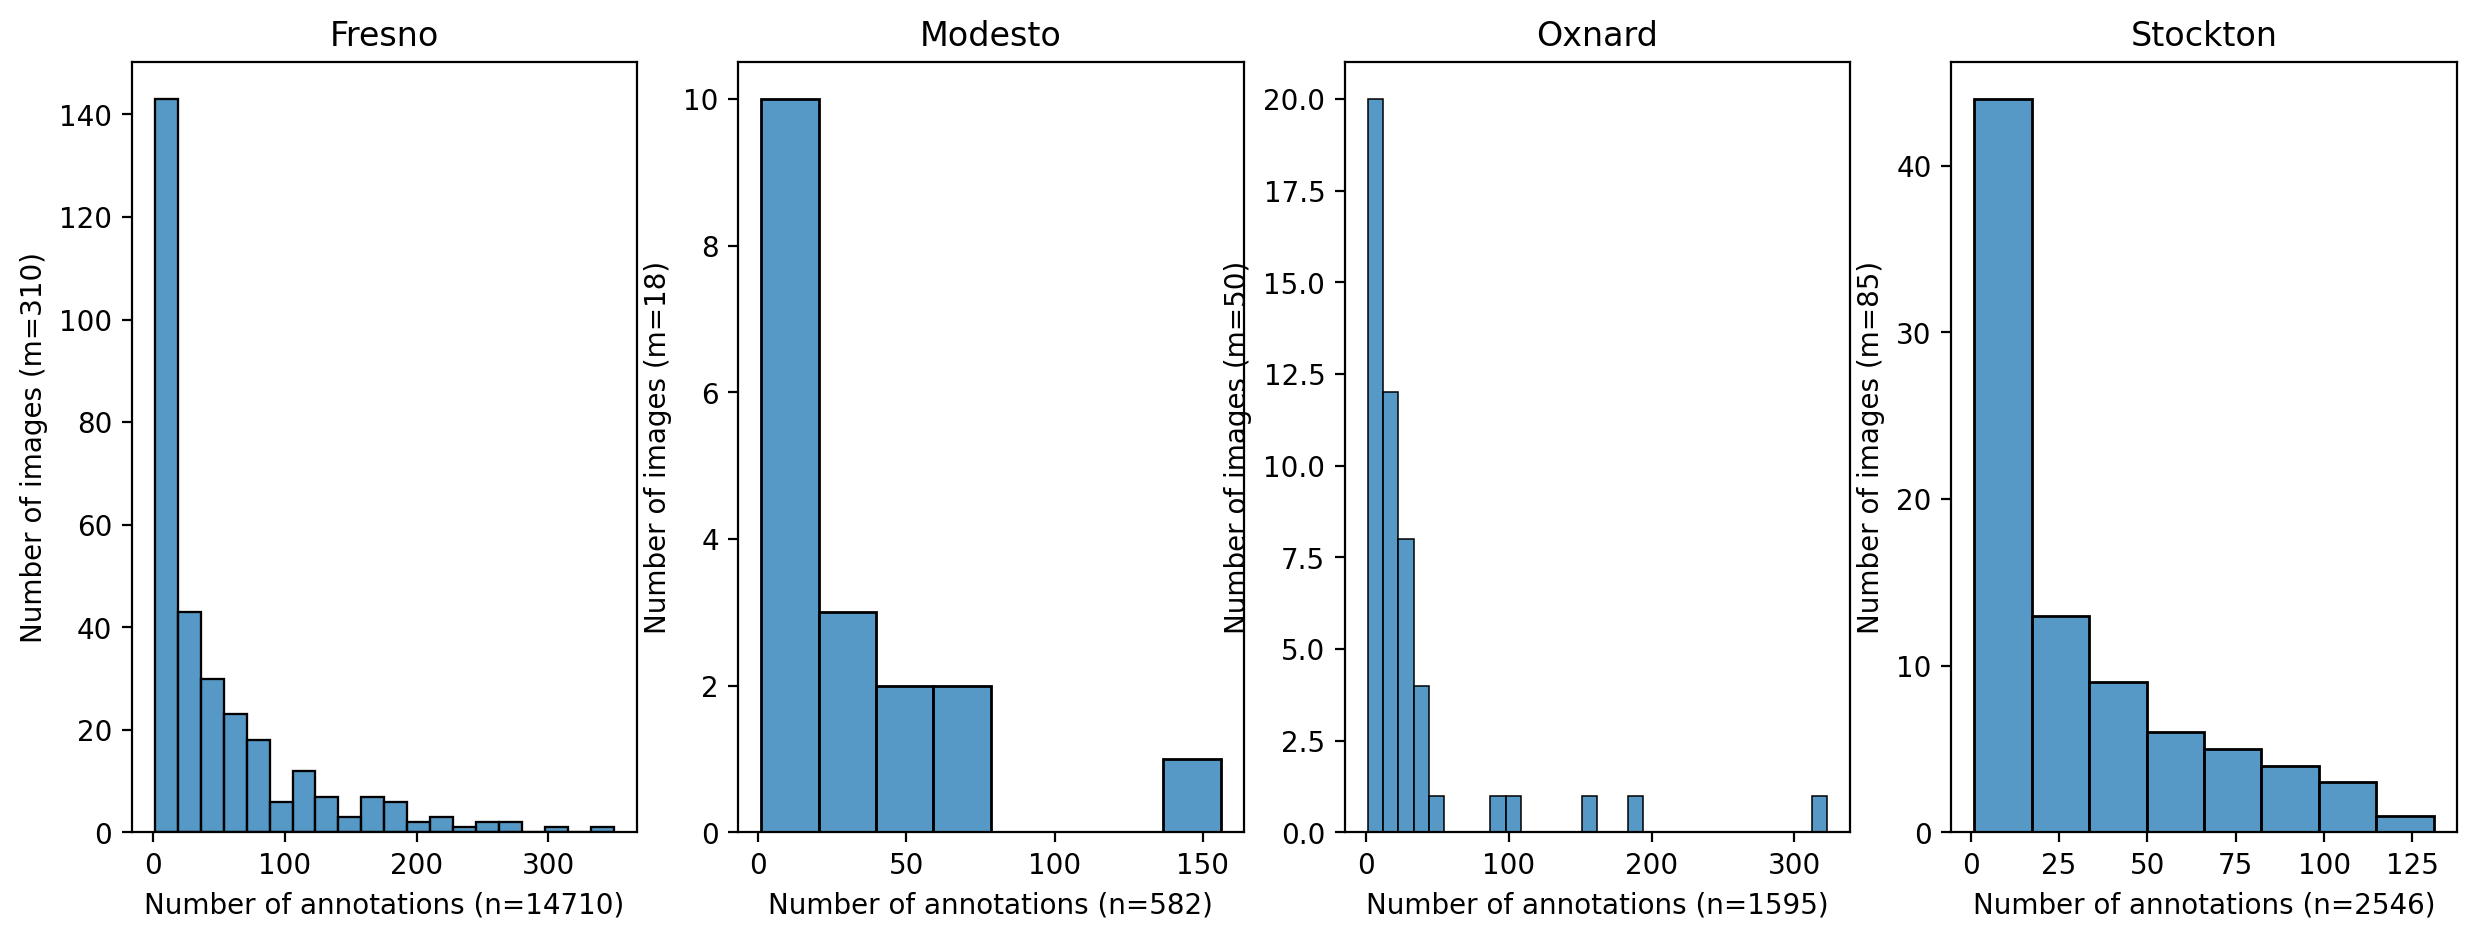

In [179]:
# Plot in multiple histograms per city name
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

for i, city in enumerate(df['city'].unique()):
    # Filter data for the current city
    city_data = df[df['city'] == city]
    
    # y-axis is the number of annotations per image_name
    y_axis_data = city_data['image_name'].value_counts().values
    
    # Use Seaborn's histplot to create the histogram
    sns.histplot(y_axis_data, kde=False, ax=ax[i])
    
    ax[i].set_title(city)
    ax[i].set_xlabel(f'Number of annotations (n={city_data.shape[0]})')
    ax[i].set_ylabel(f'Number of images (m={len(y_axis_data)})')
    
plt.show()
    

In [180]:
# Count number of occurences per image_name
image_counts = df['image_name'].value_counts()

# Find the mean
mean = image_counts.mean()

# Coun the number of images with more than the mean number of annotations
more_than_mean = (image_counts > mean).sum()

# Ratio of images with more than the mean number of annotations
ratio = more_than_mean / len(image_counts)
ratio

0.30885529157667385

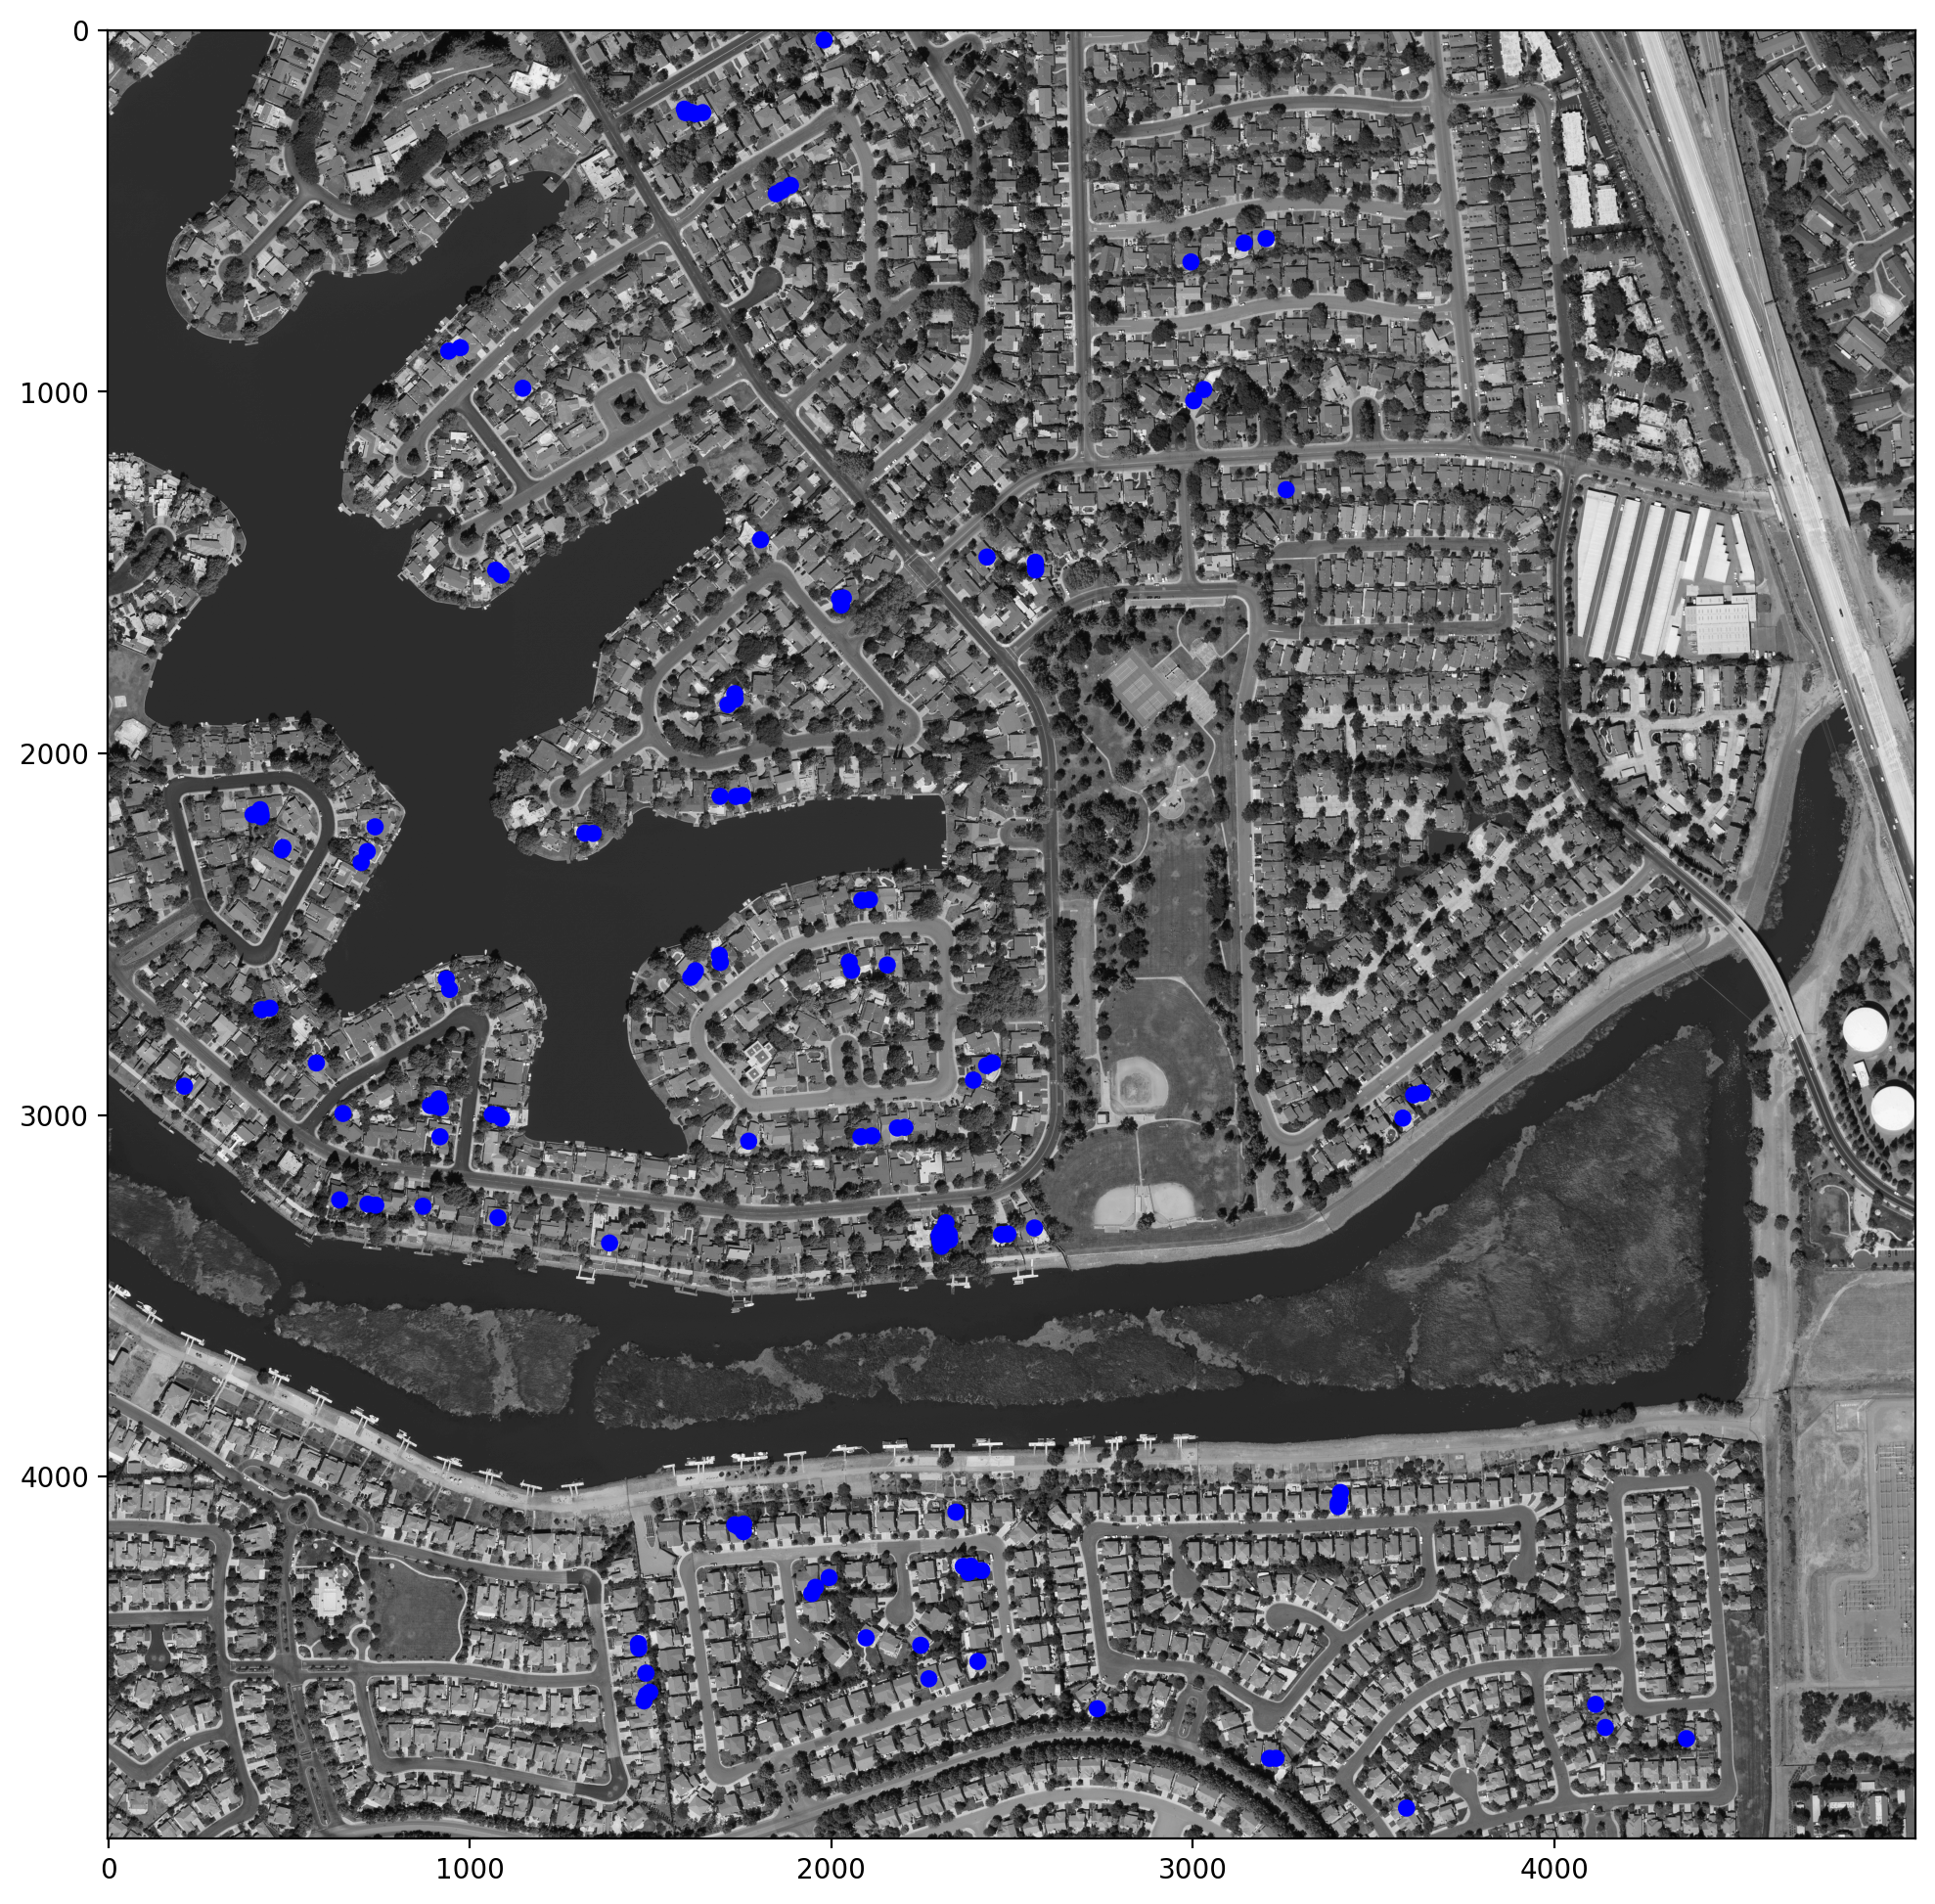

In [181]:
# Plot centers of all solar arrays for a given satellite image

def plot_centroids(df, city, img_id):
    # Read in image
    img = io.imread(f"dataset/imgs/{city}/{img_id}.tif")
    
    # Extract centroid coordinates from dataframe    
    arrays_sub = df[df['image_name'] == img_id]
    coordinates = zip(list(arrays_sub['centroid_longitude_pixels']),
                      list(arrays_sub['centroid_latitude_pixels']))

    # Display image
    fig,ax = plt.subplots(figsize=(12, 12))

    ax.imshow(img[:,:,1], cmap=cm.gray)
    
    # Plot a circle for each solar panel array
    for x, y in coordinates:
        centroid = Circle((x, y), 20, color='blue')
        ax.add_patch(centroid)
        

    plt.show()
    
# Plot the centroid from the image in Stockton with the highest number of solar arrays
stockton_max_id = df[df['city'] == 'Stockton']['image_name'].value_counts().idxmax()

plot_centroids(df, 'Stockton', stockton_max_id)

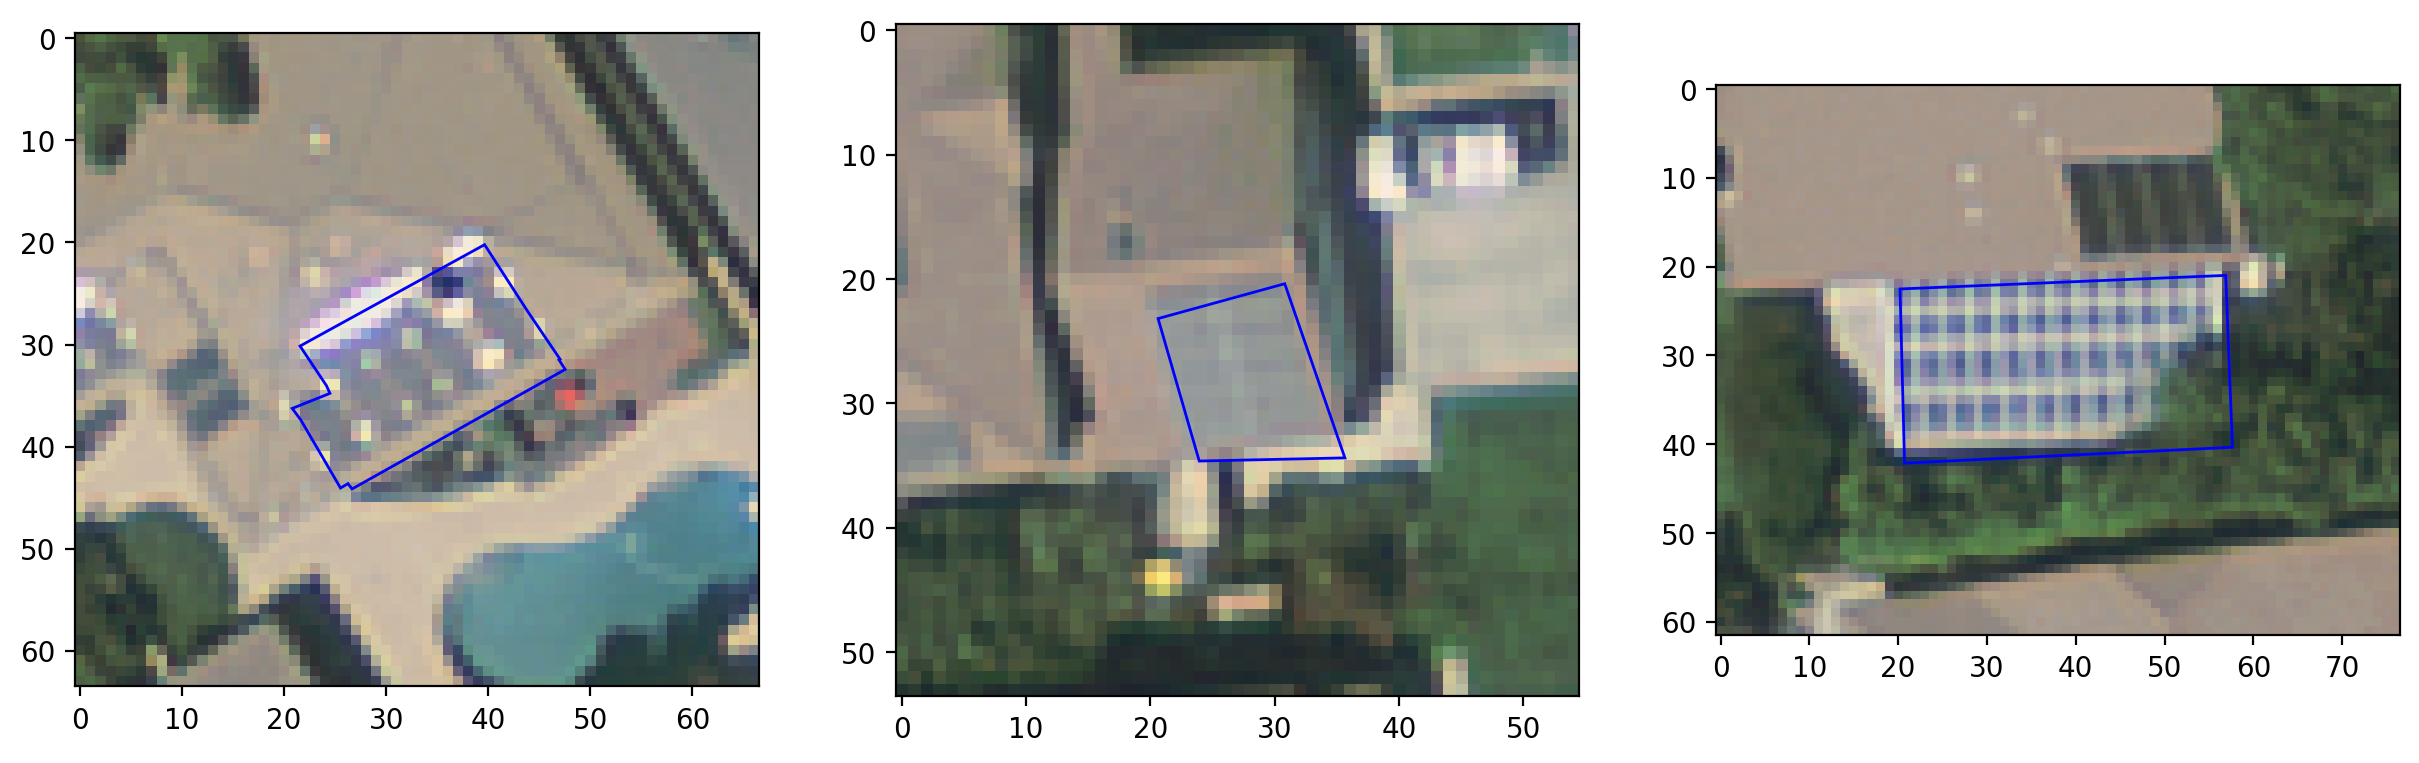

In [182]:
# Plot the polygon vertices of a solar array for a given satellite image

def plot_polygon(df, city, img_id):
    # Read in image
    img = io.imread(f"dataset/imgs/{city}/{img_id}.tif")
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        # Get the i th polygon
        arrays_sub = df[(df['image_name'] == img_id)].iloc[[-i]]
    
        vertices = arrays_sub['polygon_vertices'].values[0]
        vertices = np.array(vertices).reshape(-1, 2)
        
        # Crop image to the bounding box of the polygon
        min_x, min_y = vertices.min(axis=0)
        max_x, max_y = vertices.max(axis=0)
        
        # Convert them into integers
        min_x, min_y = int(min_x), int(min_y)
        max_x, max_y = int(max_x), int(max_y)
        band = 20
        resized_img = img[min_y-band:max_y+band, min_x-band:max_x+band]
        
        # Plot the image in color
        ax[i].imshow(resized_img)
        
        # Plot the polygon using the matplotlib Polygon patch
        resized_vertices = vertices - [min_x-band, min_y-band]
        polygon = Polygon(resized_vertices, closed=True, fill=False, edgecolor='b')
        ax[i].add_patch(polygon)
    
    plt.show()
    
# Plot the polygon vertices from the image in Stockton with the highest number of solar arrays
plot_polygon(df, 'Stockton', stockton_max_id)

## 3. Image Segmentation

In [183]:
# Use ipywidgets to experiment with algorithm parameters
def plot_segments(img, kernel_size=2, max_dist=10, ratio=0.5):
    # Extract a 100x100 pixel region from the image
    img = img[0:100, 0:100]
    
    fig, axes = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)
    fig.tight_layout()
    
    axes[0].imshow(img)
    axes[0].set_title("Original")

    axes[1].imshow(mark_boundaries(img, quickshift(img, kernel_size=kernel_size, max_dist=max_dist, ratio=ratio)))
    axes[1].set_title("Quickshift Segmentations")

    plt.show()

img = io.imread(f"dataset/imgs/Stockton/{stockton_max_id}.tif")
interact(plot_segments, img=fixed(img), kernel_size=(1,10,1), max_dist=(0,20,1), ratio=(0,1,0.1))

interactive(children=(IntSlider(value=2, description='kernel_size', max=10, min=1), IntSlider(value=10, descri…

<function __main__.plot_segments(img, kernel_size=2, max_dist=10, ratio=0.5)>

## 4. Feature Extraction

### Spatial Features

In [184]:
def segment_features_shape(segments, img_id='na', quickshift=False):

    # Skimage segmentation algorithms assign a "0" label, however, measure.regionprops only reads labels > 0 
    # If quickshift == True, add 1 to all segment labels
    if quickshift:
        segments = segments + 1
        
    # Convert labels to int and generate unique labels list
    segments = segments.astype(int)
    segment_labels = np.unique(segments[segments > 0])

    # For each region/segment, create regionprops object and extract features
    region_props_all = measure.regionprops(segments)    
    region_features = {}
        
    for i, region in enumerate(region_props_all):    

        shape_features = {}

        shape_features['image_id'] = img_id
        shape_features['segment_id'] = segment_labels[i]
        shape_features['perimeter'] = region.perimeter
        shape_features['area'] = region.area
        shape_features['circleness'] = (4 * np.pi * region.area) / (max(region.perimeter, 1) ** 2)
        shape_features['centroid'] = region.centroid
        shape_features['coords'] = region.coords

        region_features[segment_labels[i]] = shape_features
    
    index = ['image_id', 'segment_id', 'perimeter', 'area', 'circleness', 'centroid', 'coords']
    
    shape_df = pd.DataFrame(region_features, index=index).T
    
    return shape_df

### Color Features

In [185]:

def segment_features_color(img, segments, img_id='na', quickshift=False):
    
    # Skimage segmentation algorithms assign a "0" label, however, measure.regionprops only reads labels > 0 
    # If quickshift == True, add 1 to all segment labels
    if quickshift:
        segments = segments + 1
        
    # Convert labels to int and generate unique labels list
    segments = segments.astype(int)
    segment_labels = np.unique(segments[segments > 0])

    # For each segment and channel, calculate summary stats    
    channels = ['r','g','b']    
    region_features = {}
    
    for label in segment_labels:
        region = img[segments == label]
        
        color_features = {}        
               
        for i, channel in enumerate(channels):
            values = describe(region[:,i])
            
            color_features['image_id'] = img_id
            color_features['segment_id'] = label
            color_features[channel + '_min'] = values.minmax[0]
            color_features[channel + '_max'] = values.minmax[1]
            color_features[channel + '_mean'] = values.mean
            color_features[channel + '_variance'] = values.variance
            color_features[channel + '_skewness'] = values.skewness
            color_features[channel + '_kurtosis'] = values.kurtosis
            
        region_features[label] = color_features
        
    index = ['image_id','segment_id','r_min','r_max','r_mean','r_variance','r_skewness',
         'r_kurtosis','g_min','g_max','g_mean','g_variance','g_skewness','g_kurtosis',
         'b_min','b_max','b_mean','b_variance','b_skewness','b_kurtosis']
        
    color_df = pd.DataFrame(region_features, index=index).T
        
    return color_df

## 5. Building the Dataset

In [186]:
# Create a mask for all solar panels in the image, with each labeled by its polygon_id

def panel_mask(df, img_id, use_labels=False):
  
    # Identify city in order to navigate to correct directory 
    city = df[df['image_name'] == img_id]['city'].values[0]

    # Read in image
    img = io.imread(f"dataset/imgs/{city}/{img_id}.tif")
    
    # Select polygon vertices for all polygons in image
    vertices = df[df['image_name'] == img_id]['polygon_vertices'].values
    labels = df[df['image_name'] == img_id]['polygon_id'].values
    
    # Create scaffolding for mask
    mask = np.zeros((img.shape[0],img.shape[1]))
    mask[mask == 0] = np.nan
        
    # Option to use custom labels for each panel array
    if use_labels == False:
        poly_data = enumerate(vertices, 1)
    else:
        poly_data = zip(labels, vertices)
        
    # Iterate through vertices and assign labels to pixels
    for i, poly in poly_data:
        x = np.array([vert[0] for vert in poly])
        y = np.array([vert[1] for vert in poly])
        
        mask[polygon(x, y, shape=(img.shape[0],img.shape[1]))] = i 
        mask[polygon_perimeter(x, y,shape=(img.shape[0],img.shape[1]))] = i

    return mask

In [187]:
# Create a series of random windows that do not overlap with any solar panels

def no_panel_mask(panel_mask, window_size=100, windows=20):
    
    # Create scaffolding for mask 
    panels = panel_mask.copy() 
    
    mask = np.zeros(panels.shape)
    mask[mask == 0] = np.nan
        
    rows = panels.shape[0]
    cols = panels.shape[1]
        
    # Create i number of random windows with no panels
    for i in range(windows): 
    
        search = True
        
        # Iterate until random window found
        while search:

            random_x = np.random.randint(0, rows - window_size + 1)
            random_y = np.random.randint(0, cols - window_size + 1)
            random_window = panels[random_x: random_x + window_size, random_y: random_y + window_size]

            # End search when random window is all nan, i.e. does not overlap with any panels
            if np.isnan(random_window).sum() == random_window.size:
                
                # Update mask to include new random window
                mask[random_x: random_x + window_size, random_y: random_y + window_size] = i + 1
                
                # Update panel_mask copy to avoid duplicate random window on next iteration
                panels[random_x: random_x + window_size, random_y: random_y + window_size] = 0
                
                # Go to next window 
                search = False
                
    return mask

In [188]:
# Return masks

def return_masks(df, img_id):
    
    # Create panel mask 
    panels = panel_mask(df, img_id, use_labels=True)
    
    # Create no panel mask 
    no_panels = no_panel_mask(panels, window_size=60, windows=25)
    
    return panels, no_panels

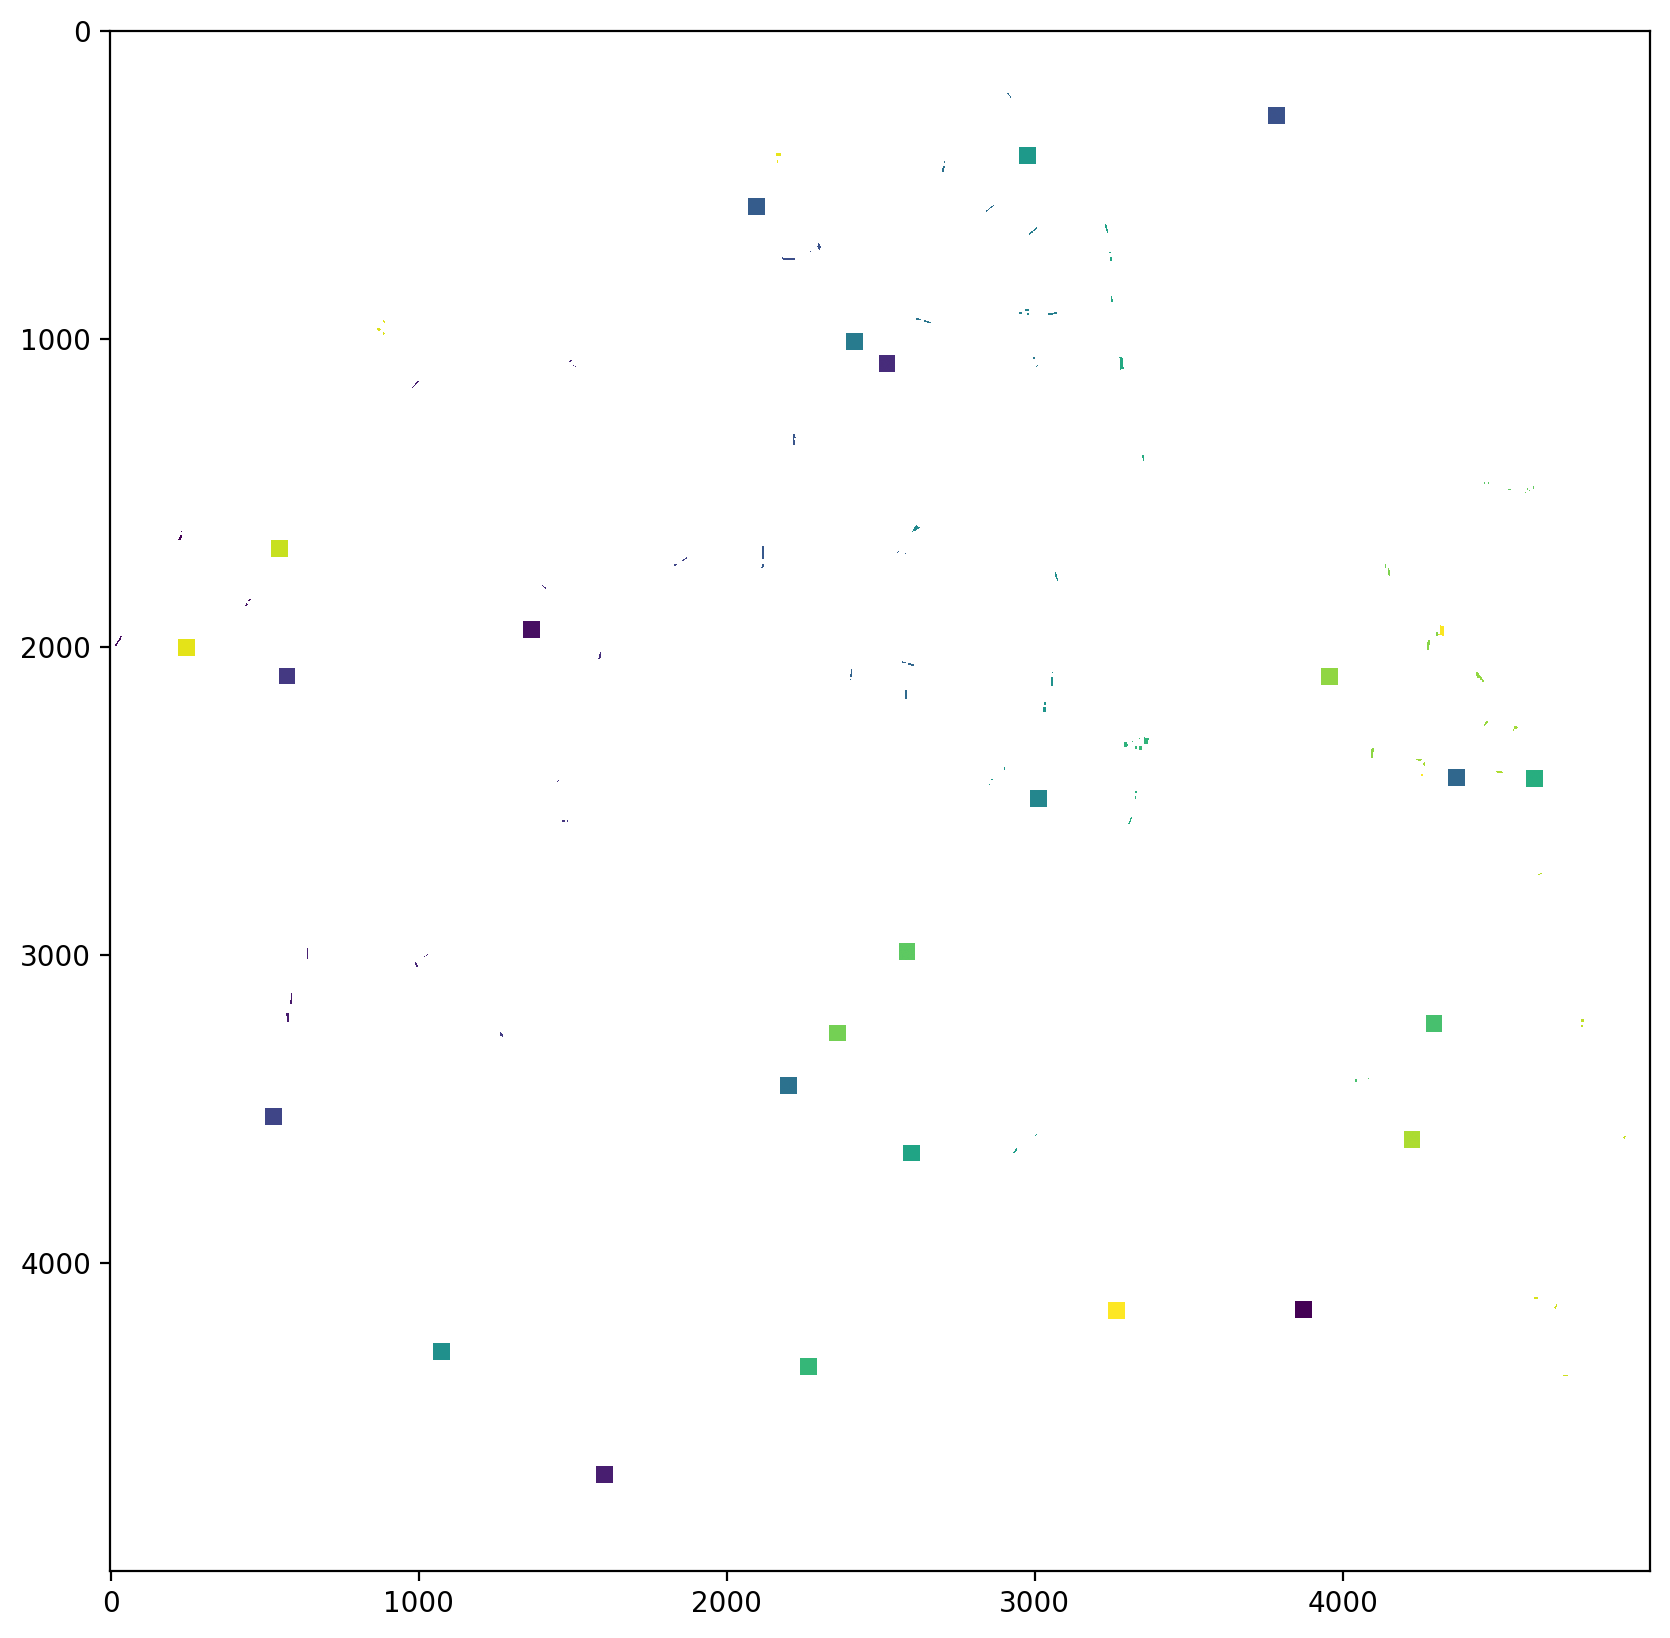

In [189]:
# Create masks for an example image and plot

fig, ax = plt.subplots(figsize=(10,10))

masks = return_masks(df, stockton_max_id)

ax.imshow(masks[0])
ax.imshow(masks[1])
    
plt.show()

In [195]:
# Return features for all solar panels

def extract_pos_features(df, img_id, quickshift=False):
    
    # Identify city in order to navigate to correct directory 
    city = df[df['image_name'] == img_id]['city'].values[0]
    
    # Read in image
    img = io.imread(f"dataset/imgs/{city}/{img_id}.tif")
    
    # Create panel mask 
    segments_panels = panel_mask(df, img_id, use_labels=True)
    
    # Extract shape features
    shape_df = segment_features_shape(segments_panels, img_id, quickshift=quickshift)
        
    # Extract color features
    color_df = segment_features_color(img, segments_panels, img_id, quickshift=quickshift)

    # Combine features into single dataframe
    features_df = shape_df.merge(color_df, how='inner', on=['image_id','segment_id'])
    
    return features_df


In [196]:
# Return features for regions without solar panels

def extract_neg_features(df, img_id, window_size=100, windows=20):
    
    # Identify city in order to navigate to correct directory 
    city = df[df['image_name'] == img_id]['city'].values[0]
    
    # Read in image
    img = io.imread(f"dataset/imgs/{city}/{img_id}.tif")
                       
    # Create panel mask 
    segments_panels = panel_mask(df, img_id, use_labels=True)

    # Create no panel mask 
    windows_no_panels = no_panel_mask(segments_panels, window_size=window_size, windows=windows)
    windows_labels = np.unique(windows_no_panels[windows_no_panels > 0])

    frames = []
    
    for label in windows_labels:

        # Extract window from image
        window_img = img[windows_no_panels == label].reshape((window_size, window_size, 3))
        
        # Divide window into segments using Quickshift segmentation algorithm 
        segments_quick = quickshift(window_img, kernel_size=3, max_dist=8, ratio=0.65)
        segments_labels = np.unique(segments_quick)

        # Extract shape features
        shape_df = segment_features_shape(segments_quick, img_id, quickshift=True) 

        # Extract color features
        color_df = segment_features_color(window_img, segments_quick, img_id, quickshift=True)

        # Combine features into single dataframe
        features_df = shape_df.merge(color_df, how='inner', on=['image_id','segment_id'])
        
        # Append to list to facilitate aggregation
        frames.append(features_df)
        
    return pd.concat(frames)


In [197]:
# Input image(s) and feed through entire pipeline, return df of results

def process_images(df, images):
    
    frames = []
    
    for img_id in images:
        
        pos_features = extract_pos_features(df, img_id)
        pos_features['panel_class'] = 1

        neg_features = extract_neg_features(df, img_id, window_size=60, windows=25)
        neg_features['panel_class'] = 0

        combined_features = pd.concat([pos_features, neg_features])
        combined_features.dropna(inplace=True)
        
        frames.append(combined_features)
    
    return pd.concat(frames).reset_index(drop=True)

In [198]:
# Create a final_df with all image data except the Fresno images
cities = df['city'].unique()
cities = cities[cities != 'Fresno']

images = df[df['city'].isin(cities)]['image_name'].unique()
processed_df = process_images(df, images)

/tmp/ipykernel_8776/1294698648.py:9: RuntimeWarning: invalid value encountered in cast
  segments = segments.astype(int)
/tmp/ipykernel_8776/1284825549.py:9: RuntimeWarning: invalid value encountered in cast
  segments = segments.astype(int)
/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1081: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1081: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1081: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/

## 6. Classification

In [201]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report
from sklearn.metrics import roc_curve, auc

In [202]:
processed_df.shape

(63226, 26)

In [203]:
# Create X and y data
excluded = ['panel_class', 'image_id', 'segment_id', 'centroid', 'coords', 'r_skewness', 
            'g_skewness', 'b_skewness','r_kurtosis', 'g_kurtosis', 'b_kurtosis']

X_cols = [col for col in processed_df.columns if col not in excluded]

ss = StandardScaler()

X = processed_df[X_cols]
Xn = ss.fit_transform(X)

y = processed_df['panel_class']
y_base = max(np.mean(y), 1 - np.mean(y))

# Split data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.3, stratify=y)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(44258, 15) (18968, 15)
(44258,) (18968,)


In [204]:
# Function to plot precision recall curve

def plot_precision_recall(y_true, y_prob, title='Precision Recall Curve'):
    
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

    fig, ax = plt.subplots(figsize=(7,5))

    plt.plot(recall, precision, 'b')
    plt.plot([1,0], [0,1], '--r')
    
    plt.title(title, fontsize=16)   
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)

    plt.show()

In [205]:
# Function to plot ROC curve

def plot_roc(y_true, y_prob, title='Receiver Operating Characteristic'):
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    fig, ax = plt.subplots(figsize=(7,5))

    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.3f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    
    plt.title(title, fontsize=16)
    plt.xlabel('False Positive Rate (Fall-out)', fontsize=14)
    plt.ylabel('True Positive Rate (Recall)', fontsize=14)
    plt.legend(loc='lower right')

    plt.show()

In [206]:
# Function to plot confusion matrix, normalized=True returns cm in the form of percentages

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Greens, normalize=False, title='Confusion Matrix'):
    
    matrix = confusion_matrix(y_true, y_pred, labels=[1,0])

    fig, axes = plt.subplots(figsize=(5,5))
    fig.tight_layout()
    
    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        plt.title(title, fontsize=16)
    else:
        plt.title(title, fontsize=16)
        
    classes = ['Solar Panels','None']
    ticks = np.arange(len(classes))

    plt.imshow(matrix, interpolation='nearest', cmap=cmap)

    thresh = matrix.max() / 2.
    
    for row in range(matrix.shape[0]):
        for col in range(matrix.shape[1]):
            plt.text(col, row, np.around(matrix[row, col], decimals=3), horizontalalignment='center', 
                     color='white' if matrix[row, col] > thresh else 'black', fontsize=14)
    
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes, rotation=45)
    
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    
    plt.colorbar()
    plt.show()

### Random Forest

In [207]:
# GridSearch a RF classifier

rf = RandomForestClassifier()

rf_params = {
    'max_features':[None,'log2','sqrt', 2,3,4,5],
    'max_depth':[1,2,3,None],
    'min_samples_leaf':np.linspace(1,101,20, dtype=int),
    'n_estimators':[50]
}

rf_gs = GridSearchCV(rf, rf_params, cv=5, verbose=1, n_jobs=-1)
rf_gs.fit(X_train, y_train)
print('Done fitting.')

Fitting 5 folds for each of 560 candidates, totalling 2800 fits


ValueError: 
All the 2800 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 1.0 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 6.2631578947368425 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 11.526315789473685 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 16.789473684210527 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 22.05263157894737 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 27.315789473684212 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 32.578947368421055 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 37.8421052631579 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 43.10526315789474 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 48.36842105263158 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 53.631578947368425 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 58.89473684210527 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 64.15789473684211 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 69.42105263157896 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 74.6842105263158 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 79.94736842105263 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 85.21052631578948 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 90.47368421052633 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 95.73684210526316 instead.

--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/manuel/TuE/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'min_samples_leaf' parameter of RandomForestClassifier must be an int in the range [1, inf) or a float in the range (0.0, 1.0). Got 101.0 instead.


In [ ]:
# Check results of Random Forest GridSearch

rf_best = rf_gs.best_estimator_
print('Random Forest GridsearchCV Results:')
print('Best Estimator', rf_best)
print('Best Parameters',  rf_gs.best_params_)
print('Best Score', '%0.4f' % rf_gs.best_score_, '\n')

# Check results against hold out test set 

print('Cross Validation on Test Set:')
print('Score: ', '%0.4f' % rf_gs.score(X_test, y_test))
print('Baseline Accuracy: ', '%0.4f' % y_base)
print('Percent Better: ', '%0.4f' % ((rf_gs.score(X_test, y_test) - y_base) / (1 - y_base)))